In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns

from ray import init, rllib, tune, shutdown

In [2]:
from attack_simulator.agents import ATTACKERS
from attack_simulator.env import AttackSimulationEnv
from attack_simulator.graph import AttackGraph, SIZES

In [3]:
graphs = [AttackGraph(dict(graph_size=size)) for size in SIZES]
attackers = list(ATTACKERS)
attackers

AttackGraph(en2720.yaml[tiny], 2 services, 7 attack steps)
AttackGraph(en2720.yaml[small], 5 services, 27 attack steps)
AttackGraph(en2720.yaml[medium-small], 9 services, 44 attack steps)
AttackGraph(en2720.yaml[medium], 13 services, 56 attack steps)
AttackGraph(en2720.yaml[large], 16 services, 62 attack steps)
AttackGraph(en2720.yaml[extra-large], 16 services, 65 attack steps)
AttackGraph(en2720.yaml[full], 18 services, 78 attack steps)


['well-informed', 'informed', 'round-robin', 'random']

In [4]:
class NoAction(rllib.policy.Policy):
    def compute_actions(self, observations, *args, **kwargs):
        # FIXME: use a `numpy` array as a temporary workaround for
        #        https://github.com/ray-project/ray/issues/10100
        return np.zeros(len(observations)), [], {}

    def get_weights(self):
        return {}

    def set_weights(self, weights):
        pass


no_action = rllib.agents.trainer_template.build_trainer(name="NoAction", default_policy=NoAction)

In [5]:
import pandas as pd


class RolloutAggregator:
    def __init__(self, **kwargs):
        self._kwargs = kwargs
        self._episodes = []

    def begin_rollout(self):
        self._rewards = []

    def append_step(self, obs, action, next_obs, reward, done, info):
        self._rewards.append(reward)

    def end_rollout(self):
        self._episodes.append(
            dict(self._kwargs, episode_reward=sum(self._rewards), episode_length=float(len(self._rewards)))
        )

    def to_df(self):
        return pd.DataFrame(self._episodes)

In [6]:
if os.path.isdir("/var/run/secrets/kubernetes.io"):  # inside k8s pod
    args = dict(address="auto")
else:
    # listen on all interfaces inside a container for port-forwarding to work
    dashboard_host = "0.0.0.0" if os.path.exists("/.dockerenv") else "127.0.0.1"
    args = dict(num_cpus=4, dashboard_host=dashboard_host)

# ALTERNATIVE: use the "Ray client" to connect to a remote cluster
# Unfortunately, JupyterNotebookReporter displays an object reference
# <IPython.core.display.HTML object> instead of content...
# --- --- ---
#
# from ray.util.client import worker
#
# worker.INITIAL_TIMEOUT_SEC = worker.MAX_TIMEOUT_SEC = 1
#
# ray_client_server = 'host.docker.internal' if os.path.exists("/.dockerenv") else '127.0.0.1'
# try:
#     init(address=f'ray://{ray_client_server}:10001')
# except Connection Error:
#     pass  # TODO: try something else...

In [13]:
from ray.rllib.rollout import rollout
from tqdm import tqdm

rename = dict(
    attacker="Attacker",
    graph_size="Graph size",
    episode_length="Episode lengths",
    episode_reward="Returns",
)

num_episodes = 5  # run 5 episodes on the same environment
seeds = [0, 1, 2, 3, 6, 7, 11, 28, 42, 1337]

def generate(savename):
    init(**args)
    
    frames = []
    for graph_size in tqdm(SIZES, 'graphs'):
        graph = AttackGraph(dict(graph_size=graph_size))

        for attacker in tqdm(ATTACKERS, graph_size):
            for seed in tqdm(seeds, f'{attacker}@{graph_size}'):
                config = dict(
                    log_level='ERROR',
                    framework="torch",
                    env=AttackSimulationEnv,
                    env_config=dict(attack_graph=graph, attacker=attacker),
                    seed=seed,
                    num_workers=1,
                    create_env_on_driver=True,  # apparently, assumed by `rollout`
                )
                agent = no_action(config=config)
                aggregator = RolloutAggregator(attacker=attacker, graph_size=graph.num_attacks)
                rollout(agent, "LengthCheck", num_steps=0, num_episodes=num_episodes, saver=aggregator)
                frames.append(aggregator.to_df())
    shutdown()
    results_df = pd.concat(frames, ignore_index=True).rename(columns=rename)
    results_df.to_csv(savename)
    return results_df

In [8]:
%%capture noise --no-stderr

savename = "length-rollout.csv"

df = generate(savename) if not os.path.exists(savename) else pd.read_csv(savename, index_col=0)

In [9]:
sns.set(style="darkgrid", rc={"figure.figsize": (12, 8)})

Text(0.5, 1.0, 'Defender: no-action')

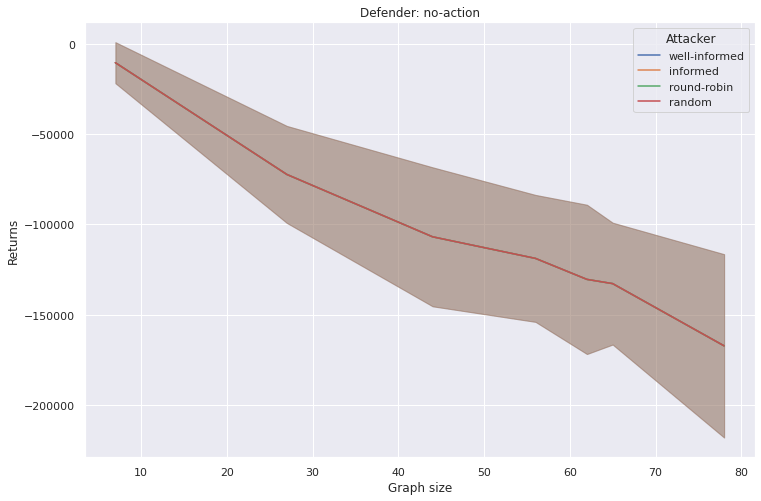

In [10]:
g = sns.lineplot(data=df, x="Graph size", y="Returns", hue="Attacker", ci="sd")
g.legend(title="Attacker", loc="upper right")
g.set_title("Defender: no-action")

Text(0.5, 1.0, 'Defender: no-action')

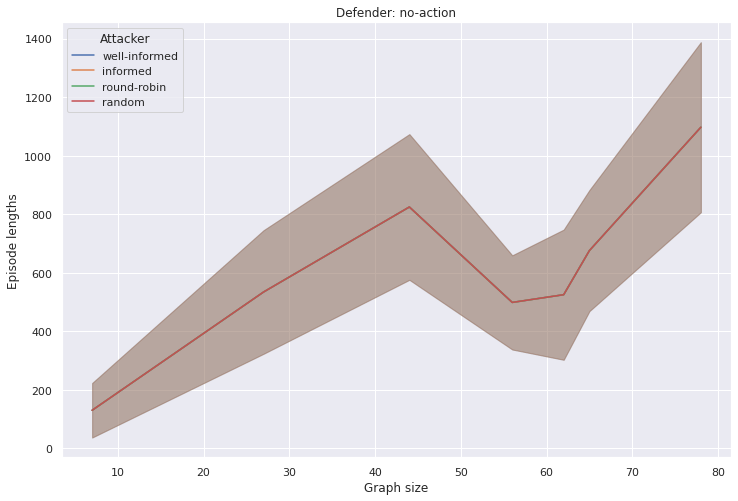

In [11]:
g = sns.lineplot(data=df, x="Graph size", y="Episode lengths", hue="Attacker", ci="sd")
g.legend(title="Attacker", loc="upper left")
g.set_title("Defender: no-action")

In [12]:
pd.set_option("display.max_columns", 32)
df.groupby("Attacker").describe()

Graph size                                                    \
                   count       mean       std  min   25%   50%   75%   max   
Attacker                                                                     
informed           350.0  48.428571  22.66523  7.0  27.0  56.0  65.0  78.0   
random             350.0  48.428571  22.66523  7.0  27.0  56.0  65.0  78.0   
round-robin        350.0  48.428571  22.66523  7.0  27.0  56.0  65.0  78.0   
well-informed      350.0  48.428571  22.66523  7.0  27.0  56.0  65.0  78.0   

              Episode lengths                                              \
                        count        mean         std   min    25%    50%   
Attacker                                                                    
informed                350.0  612.225714  350.093541  10.0  382.5  552.0   
random                  350.0  612.225714  350.093541  10.0  382.5  552.0   
round-robin             350.0  612.225714  350.093541  10.0  382.5  552.0   
well-informed           350.0  612.225714  350.093541  10.0  382.5  552.0   

                              Returns                                         \
                  75%     max   count           mean           std       min   
Attacker                                                                       
informed       824.75  1812.0   350.0 -105560.337143  58995.175005 -295176.0   
random         824.75  1812.0   350.0 -105560.337143  58995.175005 -295176.0   
round-robin    824.75  1812.0   350.0 -105560.337143  58995.175005 -295176.0   
well-informed  824.75  1812.0   350.0 -105560.337143  58995.175005 -295176.0   

                                                    
                    25%       50%       75%    max  
Attacker                                            
informed      -142558.5 -107490.5 -68995.75 -362.0  
random        -142558.5 -107490.5 -68995.75 -362.0  
round-robin   -142558.5 -107490.5 -68995.75 -362.0  
well-informed -142558.5 -107490.5 -68995.75 -362.0